In [20]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import intfeat as ifs
from pathlib import Path
import math

# Load and plot data

In [21]:
total_rows = 45840617
n_train_rows = 3000000
n_test_rows = 500000
test_row_idx = total_rows - n_test_rows

int_cols = [f'I_{k}' for k in range(1, 14)]
cat_cols = [f'C_{k}' for k in range(1, 27)]
schema = {'label': pl.Int8()} | {col: pl.Int32() for col in int_cols} | {col: pl.String() for col in cat_cols}

homedir = Path.home()
file_path = homedir / "datasets/criteo_kaggle_challenge/train.txt"

train_df = pl.read_csv(file_path, has_header=False, separator='\t', schema=schema, n_rows=n_train_rows)
test_df = pl.read_csv(file_path, has_header=False, separator='\t', schema=schema, skip_rows=test_row_idx)
df = train_df

In [22]:
pl.concat([
    df[int_cols].quantile(0.95),
    df[int_cols].quantile(0.99),
    df[int_cols].quantile(0.999),
    df[int_cols].max().cast(pl.Float64())
])

I_1,I_2,I_3,I_4,I_5,I_6,I_7,I_8,I_9,I_10,I_11,I_12,I_13
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
14.0,524.0,66.0,24.0,65535.0,458.0,56.0,42.0,414.0,2.0,9.0,4.0,27.0
37.0,2235.0,184.0,39.0,344345.0,1241.0,184.0,48.0,945.0,3.0,23.0,21.0,45.0
100.0,3575.0,944.0,58.0,860810.0,3650.0,719.0,49.0,2353.0,4.0,54.0,69.0,101.0
1209.0,18522.0,65535.0,561.0,2.539061e6,233523.0,26297.0,5064.0,19327.0,8.0,155.0,1286.0,6879.0


In [23]:
def get_cutoff(col: np.array, max_val=65536, quantile=0.99, quantile_factor=1.1):
    max_col = np.max(col)
    if max_col < max_val:
        return max_val

    high_quantile = np.quantile(col, quantile)
    return min(high_quantile * quantile_factor, max_val)

In [24]:
def get_subplots(n):
    n_plot_rows = math.floor(math.sqrt(n))
    n_plot_cols = math.ceil(n / n_plot_rows)
    return plt.subplots(n_plot_rows, n_plot_cols, figsize=(4 * n_plot_cols, 3 * n_plot_rows), layout='constrained')

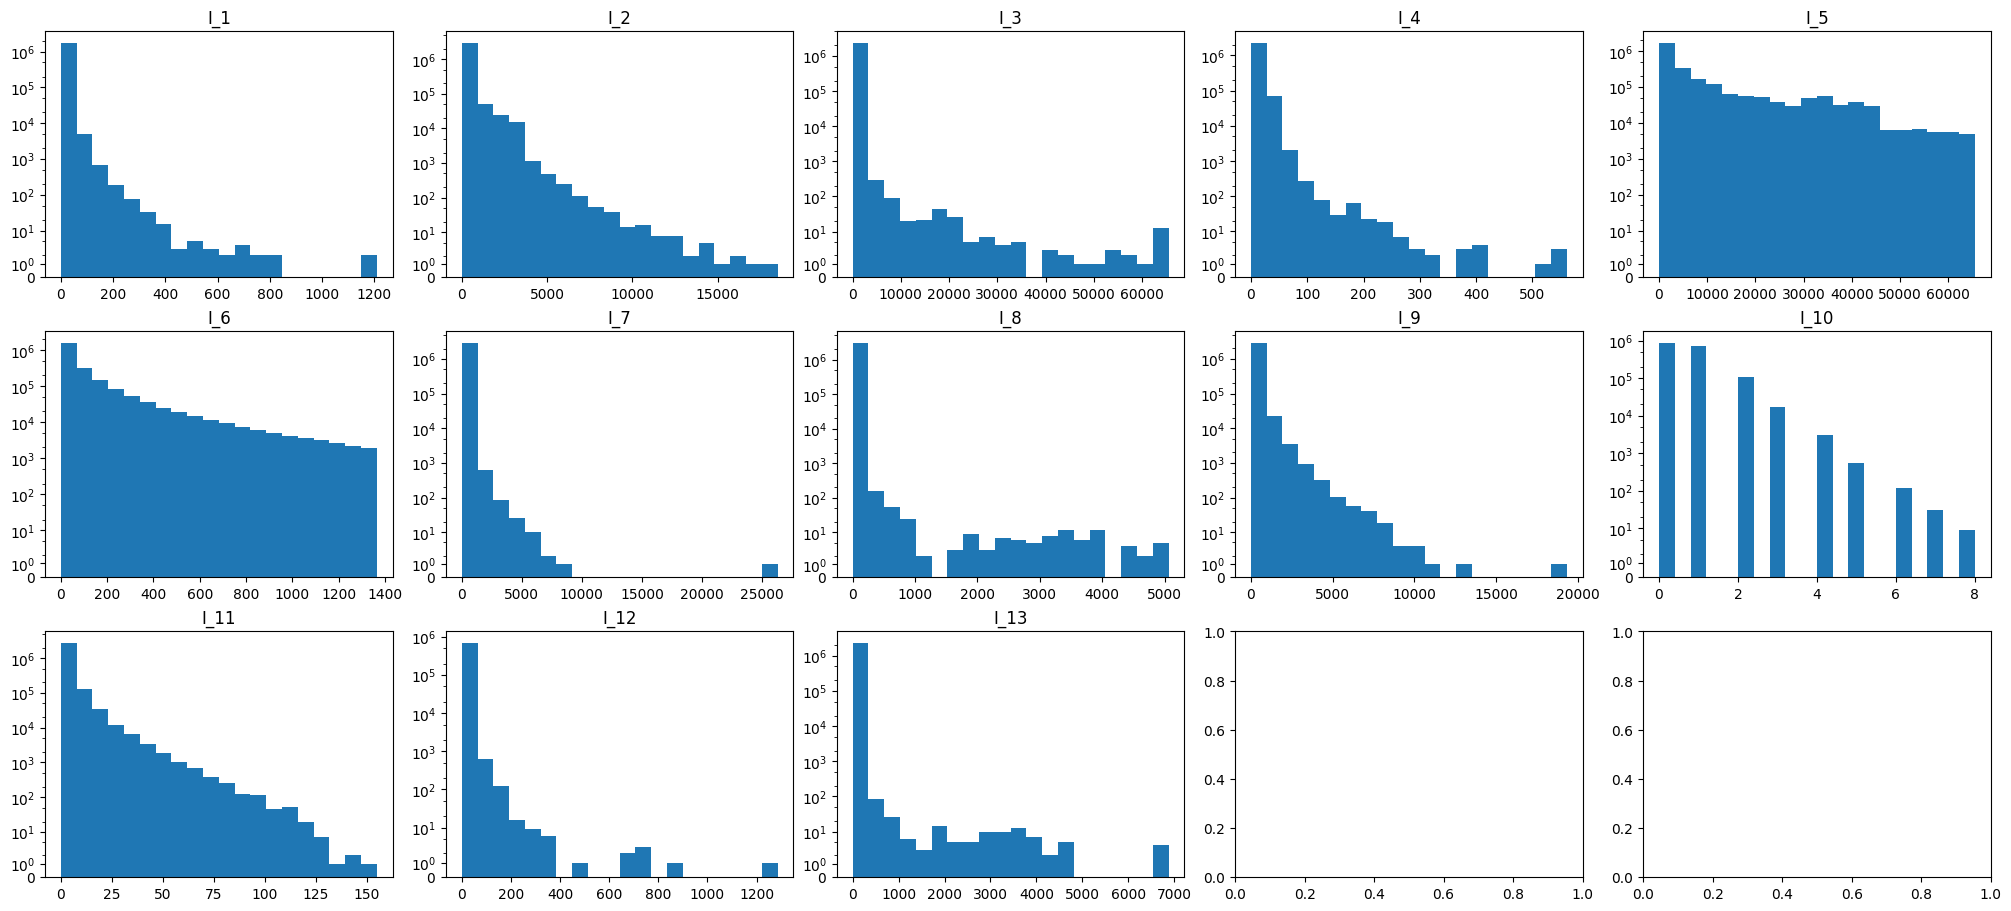

In [25]:
fig, axs = get_subplots(len(int_cols))
for ax, col in zip(axs.ravel(), int_cols):
    col_data = df[col].drop_nulls().to_numpy()
    cutoff = get_cutoff(col_data)
    col_data = col_data[col_data < cutoff]
    ax.hist(col_data, bins=20)
    ax.set_yscale('asinh')
    ax.set_title(col)
plt.show()

# Laplacian-estimation of column distributions

In [26]:
def fit_col(col) -> ifs.LaplacianHistogramFitter:
    col_data = col.drop_nulls().to_numpy()
    fitter = ifs.LaplacianHistogramFitter()
    fitter.fit(col_data)
    return fitter

In [27]:
actual_int_cols = [f'I_{k}' for k in range(1, 14) if k != 10]
fitters = [(col, fit_col(df[col])) for col in actual_int_cols]

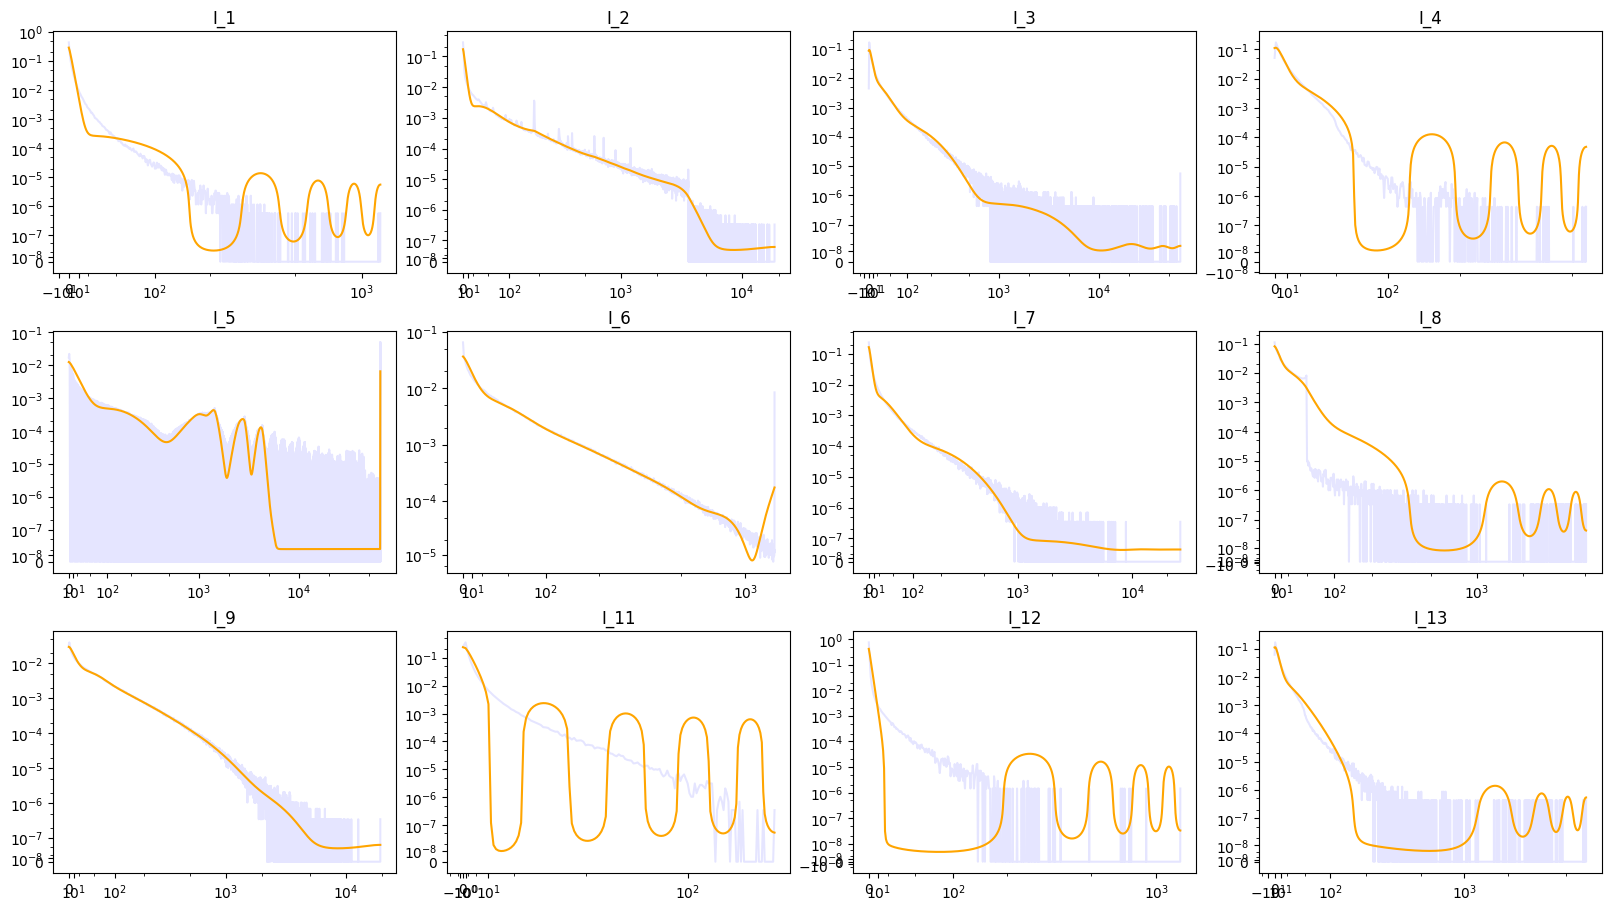

In [28]:
fig, axs = get_subplots(len(fitters))
for ax, (col, fitter) in zip(axs.ravel(), fitters):
    ax.set_title(col)
    ax.plot(np.arange(len(fitter.hist_)), fitter.hist_, color='blue', alpha=0.1)
    ax.plot(fitter.apx_hist_, color='orange')
    ax.set_xscale('asinh', linear_width=100)
    ax.set_yscale('asinh', linear_width=np.min(fitter.apx_hist_))
plt.show()

# Orthogonal basis fitting

In [29]:
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, KBinsDiscretizer, SplineTransformer
from sklearn.pipeline import make_pipeline, make_union
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.impute import SimpleImputer

In [30]:
def negative_as_missing(inp_df):
    return inp_df.select([
        pl.when(pl.col(col) >= 0).then(pl.col(col)).otherwise(pl.lit(None))
        for col in inp_df.columns
    ])

def nonnegative_as_missing(inp_df):
    return inp_df.select([
        pl.when(pl.col(col) < 0).then(pl.col(col)).otherwise(pl.lit(None))
        for col in inp_df.columns
    ])

In [31]:
pp_int_cols = [f'I_{k}' for k in range(1, 14) if k != 10]
pp_neg_cols = ['I_3']
pp_cat_cols = [f'C_{k}' for k in range(1, 27)] + ['I_10']

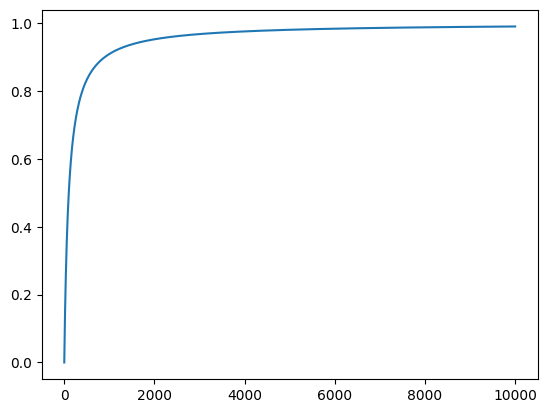

In [32]:
curvature_spec = curvature_spec=ifs.CurvatureSpec(alpha=0.01, beta=1, center=0)
plt.plot(curvature_spec.compute_weights(np.arange(10000)))

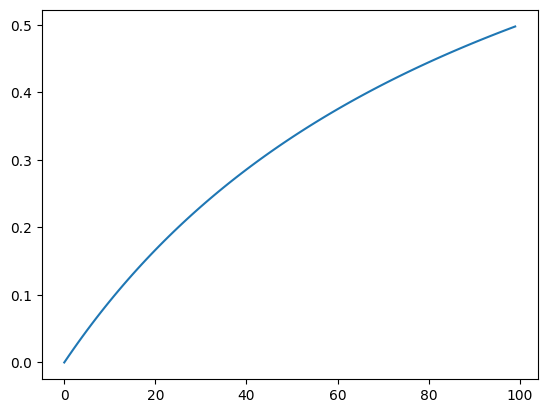

In [33]:
plt.plot(curvature_spec.compute_weights(np.arange(10000))[:100])

In [41]:
num_funcs = 20

pipeline = make_pipeline(
    make_column_transformer(
        (
            OneHotEncoder(min_frequency=10, handle_unknown='infrequent_if_exist', max_categories=30),
            pp_cat_cols
        ),
        (
            make_pipeline(
                FunctionTransformer(negative_as_missing),
                # ifs.MissingAwareColumnWrapper(
                #     ifs.StrumLiouvilleTransformer(num_funcs=num_funcs),
                #     pass_through_missing=True
                # )
                # ifs.MissingAwareColumnWrapper(
                #     ifs.StrumLiouvilleTransformer(num_funcs=num_funcs, curvature_spec=curvature_spec),
                #     pass_through_missing=True
                # )
                # ifs.MissingAwareColumnWrapper(
                #     SplineTransformer(n_knots=num_funcs - 2, knots='uniform'),
                #     pass_through_missing=False
                # )
                # ifs.MissingAwareColumnWrapper(
                #     SplineTransformer(n_knots=num_funcs - 2, knots='quantile'),
                #     pass_through_missing=False
                # )
                # ifs.MissingAwareColumnWrapper(
                #     KBinsDiscretizer(n_bins=num_funcs, strategy='uniform', quantile_method='averaged_inverted_cdf'),
                #     pass_through_missing=False
                # )
                ifs.MissingAwareColumnWrapper(
                    KBinsDiscretizer(n_bins=num_funcs, strategy='quantile', quantile_method='averaged_inverted_cdf'),
                    pass_through_missing=False
                )
            ),
            pp_int_cols
        ),
        remainder='drop'
    ),
    LogisticRegression(solver='newton-cholesky')
)

In [42]:
def fit_params(df):
    return df.drop('label'), df['label']

In [43]:
pipeline.fit(*fit_params(train_df))

/Users/alex.shtoff/git/intfeat/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:397: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/alex.shtoff/git/intfeat/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:397: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/alex.shtoff/git/intfeat/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:397: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/alex.shtoff/git/intfeat/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:397: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bin

,steps,"[('columntransformer', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('onehotencoder', ...), ('pipeline', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [44]:
feat, labels = fit_params(test_df)
train_ll = log_loss(labels, pipeline.predict_proba(feat)[:, 1])
train_ll

0.4922150387323507

In [45]:
train_auc = roc_auc_score(labels, pipeline.decision_function(feat))
train_auc

0.745721764959259

In [ ]:
# 20 functions, 3M rows train
# ---------------------------
# SL (uniform-c):    0.4927439775540157,  0.7455550612326249
# SL (curvature):    0.4916535572885227,  0.7463552196375242
# Spline (uniform):  0.49787467579494044, 0.7380759516818196
# Spline (quantile): 0.49174711079966826, 0.7462216909059823
# KBins (uniform):   0.5098686284987813,  0.7180299142075764
# KBins (quantile):  0.4922150387323507,  0.745721764959259

In [ ]:
# 15 functions, 3M rows train
# ---------------------------
# SL (uniform-c):    0.49238149455587654, 0.7454888542394241
# SL (curvature):    0.49175166462139586, 0.7461916698940324
# Spline (uniform):  0.4989359905618497,  0.73682612804474
# Spline (quantile): 0.4919138332155927,  0.746057566207289
# KBins (uniform):   0.5111247686392991,  0.7155986686199135
# KBins (quantile):  0.4924112406425826,  0.7453385161756113

In [ ]:
# 15 functions, 2M rows train
# ---------------------------
# SL (uniform-c):    0.49256578450964117, 0.745307775212254
# SL (curvature):    0.4919395095824145,  0.7459988054531991
# Spline (uniform):  0.49936178282039356, 0.736612364284322
# Spline (quantile): 0.4921483395147802,  0.7458108255746784
# KBins (uniform):   0.5122771949070443,  0.7134620104872001
# KBins (quantile):  0.4926773552604283,  0.7450445767316437

In [ ]:
# 10 functions, 1M rows train
# ---------------------------
# SL (uniform-c):    0.4930133079256299,  0.7444970640297961
# SL (curvature):    0.4924433841657933,  0.7452386183564768
# Spline (uniform):  0.5000181778985453,  0.735052966413926
# Spline (quantile): 0.492465645851667,   0.7451900832020046
# KBins (uniform):   0.5136595778448801,  0.710525452470036
# KBins (quantile):  0.49340736980858835, 0.7439166112624852

In [ ]:
coefs = pipeline['logisticregression'].coef_.ravel()
plt.bar(np.arange(len(coefs)), coefs)